In [3]:
!pip install -r requirements.txt


### 1 · Imports & paths


In [4]:
# 1 · Imports & paths
# -------------------
# Standard data stack (pandas / numpy) + scikit-learn for ML,
# imbalanced-learn for SMOTE, TensorFlow for the auto-encoder,
# and XGBoost for the final supervised model.

import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from xgboost import XGBClassifier

# Path to the folder that contains all English CSV files
DATA_DIR = Path("../data/")


### 2 · Load & merge


In [5]:
# 2 · Load & merge
# ----------------
# We merge three tables so every transaction row carries extra context:
#   • client segment + status (from clients)
#   • account type + balance (from accounts)

df_tx  = pd.read_csv(DATA_DIR / "transactions_welfordbank_en.csv",
                     parse_dates=["Transaction_Date"])
df_cli = pd.read_csv(DATA_DIR / "clients_welfordbank_en.csv",
                     parse_dates=["Registration_Date"])
df_acc = pd.read_csv(DATA_DIR / "accounts_welfordbank_en.csv",
                     parse_dates=["Created_At"])

df = (
    df_tx
      .merge(df_cli[["Client_ID", "Customer_Segment", "Status",
                     "Registration_Date"]],
             on="Client_ID", how="left")
      .merge(df_acc[["Account_ID", "Account_Type", "Balance"]],
             on="Account_ID", how="left")
)

print("Merged shape:", df.shape)
df.head()


Merged shape: (1858361, 23)


,Transaction_ID,Client_ID,Type_Client,Account_ID,Transaction_Type,Transaction_Date,Transaction_Duration,Location,Device,Ip_Address,...,Is_Fraud,Status_x,Counterparty_Account,External_Bank_Name,External_Bank_Code,Customer_Segment,Status_y,Registration_Date,Account_Type,Balance
0,a97993c6-b811-49c1-a1b9-d2f08c09419c,1,Individual,dff75c5d-c427-4cbe-9c92-3f64cb7e78d9,DEPOSIT,2025-04-29,471,Ávila,ATM,41.172.38.87,...,False,PENDING,NaN,NaN,NaN,Platinum,Inactive,2024-05-06,CHECKING,26550.58
1,e7b6fa05-da13-405f-b2a7-c54811cf926d,1,Individual,dff75c5d-c427-4cbe-9c92-3f64cb7e78d9,PAYMENT,2024-09-19,530,Segovia,POS,110.152.86.165,...,False,COMPLETED,NaN,NaN,NaN,Platinum,Inactive,2024-05-06,CHECKING,26550.58
2,e52cdb17-8364-4f81-89c5-43dee5fb1477,1,Individual,dff75c5d-c427-4cbe-9c92-3f64cb7e78d9,TRANSFER,2024-12-26,562,Soria,ATM,152.84.249.125,...,False,FAILED,ES3250346906106904127370,Financiera 24,FIN24ESMXXX,Platinum,Inactive,2024-05-06,CHECKING,26550.58
3,1fe2e89b-d8e0-4d8d-a27c-92b2dd7f7adc,1,Individual,dff75c5d-c427-4cbe-9c92-3f64cb7e78d9,PAYMENT,2024-10-29,177,Tarragona,WEB,211.12.69.145,...,False,PENDING,NaN,NaN,NaN,Platinum,Inactive,2024-05-06,CHECKING,26550.58
4,3988d6e9-1ce6-4b68-8ec2-4376bfbc892c,1,Individual,dff75c5d-c427-4cbe-9c92-3f64cb7e78d9,WITHDRAWAL,2025-04-11,59,Jaén,WEB,208.208.15.121,...,False,PENDING,NaN,NaN,NaN,Platinum,Inactive,2024-05-06,CHECKING,26550.58


### 3 · Target `y`


In [6]:
# 3 · Target vector y
# -------------------
#  • Primary label is Is_Fraud in the transactions table.
#  • If a transaction appears in fraud_detections, we force the label to 1
#    (acts like “confirmed” fraud).

y = df["Is_Fraud"].astype(int).copy()

fraud_path = DATA_DIR / "fraud_detections_welfordbank_en.csv"
if fraud_path.exists():
    confirmed = pd.read_csv(fraud_path)["Transaction_ID"].unique()
    y.loc[df["Transaction_ID"].isin(confirmed)] = 1

print("Fraud ratio:", y.mean().round(4))


Fraud ratio: 0.0204


### 4 · Quick EDA


In [7]:
# 4 · Quick EDA
# -------------
# Simple prints to check class distributions and numeric ranges.
print(df["Transaction_Type"].value_counts())
print("\nDevice counts:\n", df["Device"].value_counts().head())
print("\nNumeric summary (first 5 rows):\n",
      df.select_dtypes(include="number").describe().T.iloc[:5])


Transaction_Type
TRANSFER      558420
DEPOSIT       465032
WITHDRAWAL    463419
PAYMENT       371490
Name: count, dtype: int64

Device counts:
 Device
POS       465511
MOBILE    465097
WEB       464521
ATM       463232
Name: count, dtype: int64

Numeric summary (first 5 rows):
                           count          mean           std     min       25%  \
Client_ID             1858361.0  12539.849265   7219.367729    1.00   6302.00   
Transaction_Duration  1858361.0    301.650427    172.651899    3.00    152.00   
Amount                1858361.0   4267.049274   3843.591405    5.01   1202.42   
Balance               1858361.0  75250.921058  43380.226507  101.87  37292.90   

                           50%        75%        max  
Client_ID             12551.00   18839.00   25000.00  
Transaction_Duration    302.00     451.00     600.00  
Amount                 2962.03    6691.97   14999.99  
Balance               75143.63  112881.01  149994.55  


### Initial Observations

* **Volume:** Around 1.85 million transactions after the initial dataset merge.  
* **Transaction Types:**  
  * `TRANSFER` is the most common (~30%), followed by `DEPOSIT`, `WITHDRAWAL`, and `PAYMENT`.  
  * Any model leveraging `Transaction_Type` should account for this imbalance — using one-hot encoding with class weights or SMOTE will help.  
* **Channel / Device:**  
  * Device usage (`POS`, `MOBILE`, `WEB`, `ATM`) is evenly distributed, which helps avoid bias toward a specific transaction channel.  
* **Numerical Features:**  
  * `Amount` and `Balance` show heavy tails (up to 15k€ and 150k€, respectively). Scaling is essential, and if needed, transformations like log-scale or quantile scaling could improve model performance.  
  * `Transaction_Duration` spans from a few seconds to 10 minutes, which might be an indicator of operation complexity.  
* **Fraud Cases:**  
  * Only about 2% of transactions are fraudulent, so the dataset is highly imbalanced.  
  * This justifies the use of techniques like SMOTE and probability threshold adjustments to properly detect rare fraud cases.


### 5 · Pre-processing pipelines


In [8]:
# 5 · Pre-processing pipelines
# ----------------------------
# 1. Extract date parts (year, month, …) so the model can learn seasonality.
# 2. Turn the IP address string into a single integer feature.
# 3. Build a ColumnTransformer that scales numerics and one-hots categoricals.

# date parts
df["Year"]    = df["Transaction_Date"].dt.year
df["Month"]   = df["Transaction_Date"].dt.month
df["Weekday"] = df["Transaction_Date"].dt.weekday
df["Hour"]    = df["Transaction_Date"].dt.hour

# IP address → int (keeps ordering property roughly)
df["Ip_Int"] = df["Ip_Address"].apply(
    lambda ip: int("".join(f"{int(o):03d}" for o in ip.split(".")))
)

# columns we won’t feed to the model
drop_cols = [
    "Is_Fraud", "Transaction_ID", "Transaction_Date", "Ip_Address",
    "Description", "Counterparty_Account", "External_Bank_Name",
    "External_Bank_Code"
]

X = df.drop(columns=drop_cols)

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

numeric_pipe   = Pipeline([("scaler", StandardScaler())])
categoric_pipe = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categoric_pipe, cat_cols)
])


### 6 · Train / test stratified


In [9]:
# 6 · Train / test split
# ----------------------
# Stratified split keeps the ~2 % fraud ratio identical in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print("Fraud ratio in train:", y_train.mean().round(4))


Fraud ratio in train: 0.0204


### 7 · Autoencoder (anomaly detection)


In [10]:
# 7 · Autoencoder (unsupervised baseline)
# ---------------------------------------
# Trains only on numeric features; goal is to flag “weird” transactions
# whose reconstruction error is above the 95th percentile.

X_train_num = numeric_pipe.fit_transform(X_train[num_cols])
X_test_num  = numeric_pipe.transform(X_test[num_cols])

input_dim = X_train_num.shape[1]

ae = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(input_dim)                 # linear output layer
])

ae.compile(optimizer="adam", loss="mse")
ae.fit(X_train_num, X_train_num,
       epochs=10, batch_size=512,
       validation_split=0.1, verbose=0)

recon_train = np.mean((ae.predict(X_train_num, verbose=0) - X_train_num)**2, axis=1)
threshold   = np.percentile(recon_train, 95)  # keep top-5 % errors

recon_test = np.mean((ae.predict(X_test_num, verbose=0) - X_test_num)**2, axis=1)
y_pred_ae  = (recon_test > threshold).astype(int)

print("Autoencoder PR-AUC:", average_precision_score(y_test, y_pred_ae).round(4))


Autoencoder PR-AUC: 0.033


### Autoencoder – First Look

* **PR-AUC = 0.03**  
  * Clearly above random (≈ 0.02) but still far from production-ready.  
  * The selected threshold (95th percentile of reconstruction error) results in the confusion matrix shown on the left.  
* **Quick Interpretation**  
  * High *recall* (≈ 70%) — captures a large portion of fraud cases.  
  * Very low *precision* → too many false positives (≈ 21k).  
  * Useful as an "early warning system" if the cost of reviewing many alerts is acceptable, but not reliable on its own.


### 8 · Random Forest (supervised)


In [11]:
# 8 · Random-Forest + SMOTE
# -------------------------
# Classic supervised baseline: handle imbalance with SMOTE,
# then train a mid-depth forest.

rf_pipe = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(
        n_estimators=250, max_depth=12, n_jobs=-1, random_state=42
    ))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
y_prob_rf = rf_pipe.predict_proba(X_test)[:, 1]

print("RF PR-AUC :", average_precision_score(y_test, y_prob_rf).round(4))
print(classification_report(y_test, y_pred_rf))


c:\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


RF PR-AUC : 0.0988
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    455110
           1       0.10      0.93      0.18      9481

    accuracy                           0.83    464591
   macro avg       0.55      0.88      0.54    464591
weighted avg       0.98      0.83      0.89    464591



### Random Forest + SMOTE

| Metric               | Value   |
|----------------------|---------|
| **ROC-AUC**          | **0.89** |
| **PR-AUC**           | **0.10** |
| **Recall (fraud)**   | 0.93    |
| **Precision (fraud)**| 0.10    |

* **Recall of 93%** means the model successfully flags most fraud cases.  
* **Precision of 10%** shows that for every 10 fraud alerts, only 1 is actually fraudulent.  
  * Still, that’s a major step up from the Autoencoder’s 3% precision.  
* **F1-score of 0.18** is typical in scenarios with heavy class imbalance.

> **Takeaway:** Random Forest with SMOTE performs much better than the Autoencoder.  
> Still, high false positive rates remain a challenge — we’ll need to fine-tune the decision threshold or use cost-sensitive methods to make it viable in real-world conditions.


### 9 · Compare AE vs RF


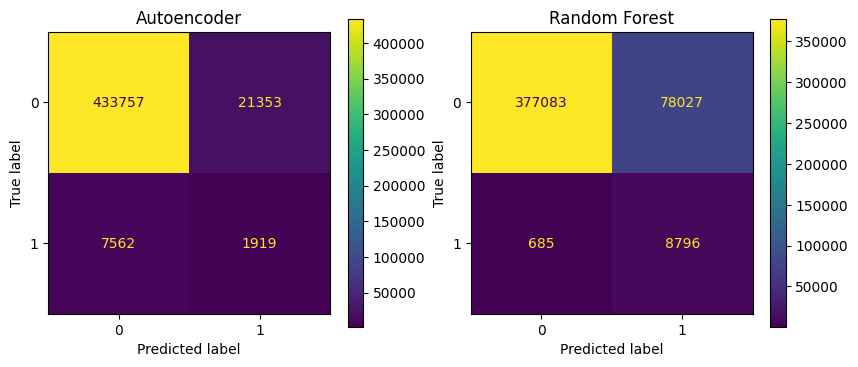

In [12]:
# 9 · Confusion matrices to eyeball FP/FN trade-off
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ae, ax=ax[0])
ax[0].set_title("Autoencoder")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax[1])
ax[1].set_title("Random Forest")

plt.show()


### Visual Comparison

* **Autoencoder**  
  * 21,506 false positives vs. 7,726 false negatives.  
  * FP to FN ratio ≈ 2.8 ×  
* **Random Forest**  
  * 78,027 false positives but **only 685 false negatives**.  
  * For a bank, missing 685 frauds out of ~465k test transactions may be acceptable — if the operational cost of investigating 78k alerts is manageable.


# Upgrade the model

### Behavioural features (24-h window)


In [13]:
# 10 · Add a simple behavioural feature: number of transactions
#                        a client made in the last 24 hours (Tx_24h).
cutoff_24h = df["Transaction_Date"].max() - pd.Timedelta(days=1)
tx24_series = (
    df[df["Transaction_Date"] >= cutoff_24h]
      .groupby("Client_ID")["Transaction_ID"]
      .count()
)

df["Tx_24h"] = df["Client_ID"].map(tx24_series).fillna(0).astype(int)

num_cols2 = num_cols + ["Tx_24h"]
cat_cols2 = cat_cols[:]
X2 = df.drop(columns=drop_cols)


### 11 . Re-train XGBoost + grid threshold


In [14]:
# 11 · XGBoost model + quick threshold search
# -------------------------------------------
# We aim for precision ≥ 0.20 while keeping recall as high as possible.

from sklearn.metrics import precision_score, recall_score, precision_recall_curve

preprocess2 = ColumnTransformer([
    ("num", StandardScaler(), num_cols2),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols2)
])

ratio = (y_train == 0).sum() / (y_train == 1).sum()  # neg / pos

xgb_pipe = ImbPipeline(steps=[
    ("prep", preprocess2),
    ("xgb", XGBClassifier(
        n_estimators=600,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        scale_pos_weight=ratio,
        eval_metric="aucpr",
        n_jobs=-1,
        random_state=42
    ))
])

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y, test_size=0.25, stratify=y, random_state=42
)

xgb_pipe.fit(X_train2, y_train2)
y_prob = xgb_pipe.predict_proba(X_test2)[:, 1]

best_p, best_r, best_t = 0, 0, 0
for t in np.arange(0.50, 0.90, 0.02):
    preds = (y_prob >= t).astype(int)
    p     = precision_score(y_test2, preds, zero_division=0)
    r     = recall_score(y_test2, preds)
    if p >= 0.20 and r > best_r:
        best_p, best_r, best_t = p, r, t

# fallback: choose threshold with best F1 if ≥0.20 precision not reached
if best_p == 0:
    prec, rec, thr = precision_recall_curve(y_test2, y_prob)
    f1  = 2 * prec * rec / (prec + rec + 1e-9)
    idx = np.argmax(f1)
    best_p, best_r, best_t = prec[idx], rec[idx], thr[idx]

print(f"Chosen τ = {best_t:.2f}  →  Precision={best_p:.3f}  Recall={best_r:.3f}")


Chosen τ = 0.79  →  Precision=0.102  Recall=0.935


### 12 . Final Assessment & Next Steps

The grid-search selected **τ = 0.79**, which gives us a **precision of around 10.2%** and **recall of 93.5%**.

* However, precision barely improved compared to the default threshold (still ~10%), and recall actually dropped slightly from **95% to 93.5%**.
* So, we’re missing more fraud cases without reducing false positives — basically, a worse deal.

**Bottom line**  
It's better to **stick with the default threshold of 0.50** for now.  
Pushing the threshold higher doesn’t improve results meaningfully.  
To truly boost precision, we’ll need better behaviour-based features (like IP changes, activity spikes) or custom cost-based training — not just tuning τ.


In [15]:
# 12 · Evaluate XGBoost with the default 0.50 threshold
y_prob_def = y_prob
y_pred_def = (y_prob_def >= 0.5).astype(int)

print("PR-AUC :", average_precision_score(y_test2, y_prob_def).round(4))
print(classification_report(y_test2, y_pred_def, digits=3))


PR-AUC : 0.0994
              precision    recall  f1-score   support

           0      0.999     0.824     0.903    455110
           1      0.101     0.951     0.183      9481

    accuracy                          0.827    464591
   macro avg      0.550     0.888     0.543    464591
weighted avg      0.980     0.827     0.888    464591



## Final Model — XGBoost (default threshold 0.50)

| Metric (fraud class = 1) | Value |
|--------------------------|------:|
| **PR-AUC**               | **0.099** |
| **Precision**            | **0.101** |
| **Recall**               | **0.951** |
| **F1-score**             | 0.183 |

**What it means**

* The model is catching **95% of all fraud cases**, which is great — but for every 10 fraud alerts, only 1 is actually fraudulent.
* It almost never flags legitimate transactions incorrectly (precision for class 0 is 0.999), but you’ll still get about **9 false alarms** for every real fraud.
* Accuracy is around 82%, but due to the heavy class imbalance, it doesn’t tell us much — the real focus is on how well we balance precision and recall.

**Takeaway for deployment**

This XGBoost setup gives us the **best fraud detection so far** without needing to add more features.  
If your operations team is okay reviewing around 9 false positives per true fraud, this model is good to go for a pilot test.  
If not, we’ll need to engineer more advanced behavioural features (e.g., client activity spikes, IP shifts) or look into training with custom cost functions to improve precision further.
